In [ ]:
import os
import csv
from math import ceil
from datetime import datetime

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
with open('raw_data.csv', 'r') as f: # 2015년 ~ 2023년 비트코인 가격 데이터
    csv_reader = csv.reader(f)
    raw_data = []

    for idx, row in enumerate(csv_reader):
        if idx == 0:
            continue
        if row[1] == 'null':
            continue

        # 5 features
        raw_data.append([
            float(row[1]), # Open price
            float(row[2]), # High price
            float(row[3]), # Low price
            float(row[6]), # Volume
            float(row[4])  # Close price
        ])

raw_data = tf.convert_to_tensor(raw_data)
print(raw_data.shape)
print('example: ', raw_data[0])

FileNotFoundError: ignored

In [ ]:
means = np.mean(raw_data, axis=0)   # mean
stds = np.std(raw_data, axis=0)     # std
print('mean:', means)
print('std: ', stds)
print('\nbefore: ', raw_data[0])

raw_data = (raw_data - np.expand_dims(means, axis=0)) / np.expand_dims(stds, axis=0)    # normalization
print('after: ', raw_data[0])

mean: [1.4744000e+04 1.5105519e+04 1.4346079e+04 1.8129101e+10 1.4751472e+04]
std:  [1.6200340e+04 1.6607906e+04 1.5731569e+04 1.9771879e+10 1.6196185e+04]

before:  tf.Tensor([2.49428e+02 2.52108e+02 2.44127e+02 3.09802e+07 2.49007e+02], shape=(5,), dtype=float32)
after:  tf.Tensor([-0.8947079 -0.8943578 -0.896411  -0.9153465 -0.8954248], shape=(5,), dtype=float32)


In [ ]:
def dataset_processing(data, length=10):
    num_data = data.shape[0] // length

    inputs = []
    targets = []
    for i in range(num_data - 1):
        start_idx = i * length
        end_idx = (i + 1) * length

        temp_data_x = data[start_idx:end_idx]               # seq
        temp_data_y = data[start_idx+length:end_idx+length] # next seq
        temp_data_y = temp_data_y[:, 1]                     # predict high value
        temp_data_y = tf.expand_dims(temp_data_y, axis=-1)

        inputs.append(temp_data_x)
        targets.append(temp_data_y)

    return (inputs, targets)

In [ ]:
def plot_prices(preds_, targets):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.gca()
    ax.plot(list(range(preds_.shape[0])), preds_, '-')
    ax.plot(list(range(preds_.shape[0])), targets, '-')
    plt.show()

In [ ]:
# rate의 비율로 train:test set을 나누고, length의 길이로 sequential data를 자름
rate = 0.8
train_data = raw_data[:int(raw_data.shape[0] * rate), :]
test_data = raw_data[int(raw_data.shape[0] * rate):, :]

length = 10
train_data = dataset_processing(train_data, length)
test_data = dataset_processing(test_data, length)
print('the number of train_dataset: ', len(train_data[0]))

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(64).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size)

the number of train_dataset:  232


In [ ]:
class Attention(tf.keras.Model):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, query, values):                      # (batch_size, 256) (batch_size, input_dim, 256)
        query = tf.expand_dims(query, axis=1)           # (batch_size, 1, 256)

        scores = query * values                         # (batch_size, input_dim, 256)
        scores = tf.reduce_sum(scores, axis=-1)         # (batch_size, input_dim)

        weights = tf.nn.softmax(scores, axis=-1)        # (batch_size, input_dim)
        weights = tf.expand_dims(weights, axis=-1)      # (batch_size, input_dim, 1)

        attention = weights * values                    # (batch_size, input_dim, 256)
        attention = tf.reduce_sum(attention, axis=1)    # (batch_size, 256)

        return attention


class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()

        self.fc = tf.keras.layers.Dense(128)    # (data_dim, 128)
        self.gru = tf.keras.layers.GRU(256, return_sequences=True, return_state=True)

    def call(self, inputs):                     # (batch_size, input_dim, data_dim)
        features = self.fc(inputs)              # (batch_size, input_dim, 128)
        values, hidden = self.gru(features)     # (batch_size, input_dim, 256) (batch_size, 256)
        return values, hidden


class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = tf.keras.layers.Dense(128)
        self.fc2 = tf.keras.layers.Dense(1)     # output shape
        self.gru = tf.keras.layers.GRU(256, return_sequences=True, return_state=True)
        self.attention = Attention()

    def call(self, x, hidden, values):                      # (batch_size, 1) (batch_size, 256) (batch_size, input_dim, 256)
        feature = self.fc1(x)                               # (batch_size, 128)
        attention = self.attention(hidden, values)          # (batch_size, 256)
        feature = tf.concat([attention, feature], axis=-1)  # (batch_size, 384)
        feature = tf.expand_dims(feature, axis=1)           # (batch_size, 1, 384)
        output, hidden = self.gru(feature, initial_state=hidden)  # (batch_size, 1, 256) (batch_size, 256)
        output = tf.squeeze(output, axis=1)                 # (batch_size, 256)
        target = self.fc2(output)                           # (batch_size, 1)

        return target, hidden

In [ ]:
learning_rate = 1e-3

n_epochs = 500
log_interval = 50
data_dim = raw_data.shape[1]

In [ ]:
encoder = Encoder()
decoder = Decoder()

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
metrics = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
@tf.function
def train_step(inputs, targets):
    loss_ = 0

    with tf.GradientTape() as tape:
        enc_outputs, hidden = encoder(inputs)
        decoder_hidden = hidden
        decoder_input = tf.zeros((targets.shape[0], 1))

        for i in range(targets.shape[1]):
            preds_, decoder_hidden = decoder(decoder_input, decoder_hidden, enc_outputs)
            loss_ += loss(targets[:, i], preds_)

    vars_ = encoder.trainable_variables + decoder.trainable_variables
    grads_ = tape.gradient(loss_, vars_)
    optimizer.apply_gradients(zip(grads_, vars_))

    return loss_


@tf.function
def test_step(inputs, targets):
    loss_ = 0
    enc_outputs, hidden = encoder(inputs)
    decoder_hidden = hidden
    decoder_input = tf.zeros((targets.shape[0], 1))

    predictions = []
    for i in range(targets.shape[1]):
        preds_, decoder_hidden = decoder(decoder_input, decoder_hidden, enc_outputs)
        loss_ += loss(targets[:, i], preds_)
        decoder_input = preds_
        predictions.append(preds_)

    predictions = tf.concat(predictions, axis=-1)
    return loss_, predictions

In [ ]:
for epoch in range(n_epochs):
    total_loss = 0

    for batch in train_dataset:
        x_batch, y_batch = batch
        batch_loss = train_step(x_batch, y_batch)
        total_loss += batch_loss

    if epoch % log_interval == 0:
        print(f'{epoch + 1} iteration: mean squared error {total_loss}')

2023-06-19 10:32:33.203493: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 8650752 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-06-19 10:32:33.203939: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE,

1 iteration: mean squared error 840.5352783203125
11 iteration: mean squared error 6.080389022827148
21 iteration: mean squared error 3.494366407394409
31 iteration: mean squared error 1.262549877166748
41 iteration: mean squared error 1.742499828338623
51 iteration: mean squared error 0.6443638801574707
61 iteration: mean squared error 0.8327857851982117
71 iteration: mean squared error 0.8844845294952393
81 iteration: mean squared error 1.0420567989349365
91 iteration: mean squared error 0.5231658220291138
101 iteration: mean squared error 0.37757670879364014
111 iteration: mean squared error 1.110342025756836
121 iteration: mean squared error 0.5907481908798218
131 iteration: mean squared error 0.8971984386444092
141 iteration: mean squared error 1.0185070037841797
151 iteration: mean squared error 0.4450814723968506
161 iteration: mean squared error 0.21943366527557373
171 iteration: mean squared error 0.20985117554664612
181 iteration: mean squared error 0.3024022579193115
191 ite

2023-06-19 10:35:51.933206: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 8650752 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-06-19 10:35:51.933539: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE,

MSE loss: 1.1395 | MAE loss: 0.2705


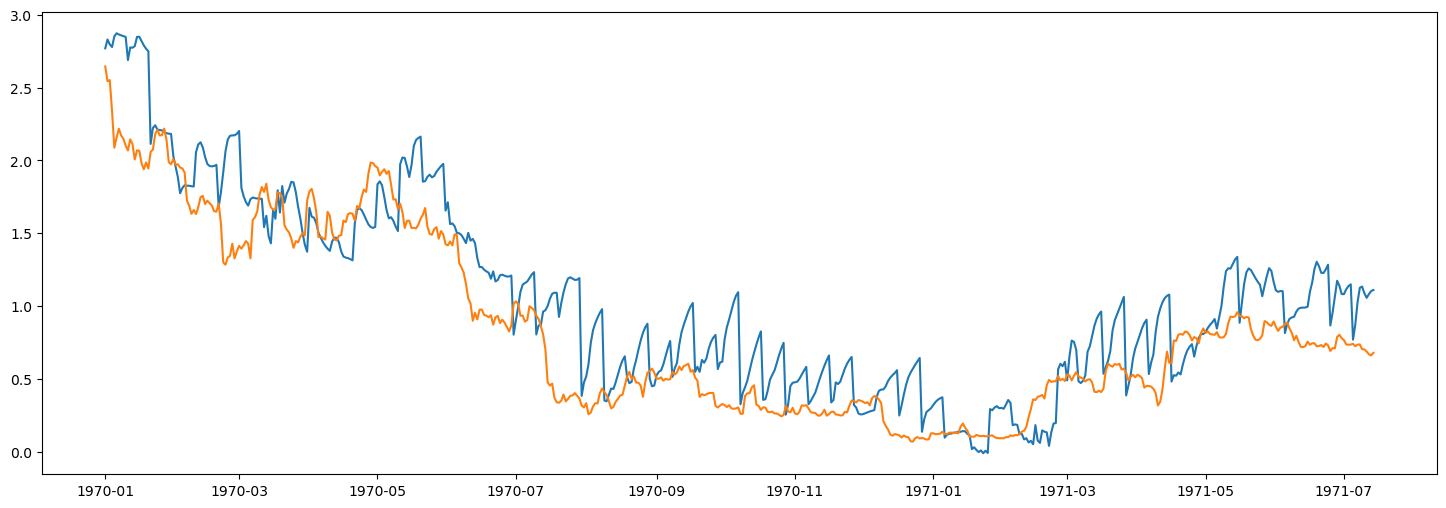

In [ ]:
preds = None
targets = None

x_batch, y_batch = next(iter(test_dataset)) # evalate on testset
x_batch = x_batch[:-1]                      # 마지막은 예측할 값이 없기 때문에 제거
y_batch = y_batch[1:]                       # 처음 값은 예측되는 값이 아니기 때문에 제거

loss_, preds_ = test_step(x_batch, y_batch)
metrics.update_state(y_batch, preds_)
print(f'MSE loss: {loss_.numpy():.4f} | MAE loss: {metrics.result().numpy():.4f}')
metrics.reset_states()

preds_ = tf.reshape(preds_, (-1, 1))
y_batch = tf.reshape(y_batch, (-1, 1))
plot_prices(preds_[:, 0], y_batch[:, 0])